In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [75]:
cd /content/drive/My\ Drive

/content/drive/My Drive


In [0]:
# !unzip PlantVillage.zip 

In [0]:
!pip install tensorflow-gpu keras tensorflow-hub

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [12]:
ls

'AI Hackathon'/             data.ipynb   PlantVillage/      Tomato_train/
 categories.json            model.h5     PlantVillage.zip   Untitled0.ipynb
'Copy of Untitled0.ipynb'   model.json   Tomato_test/


In [0]:
zip_file=tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
  fname='PlantVillage.zip', extract=True)
#data = os.path.dirname('PlantVillage/')

data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir,'train')
validation_dir = os.path.join(data_dir,'validation')



In [0]:
import shutil
train = os.path.join(data_dir, 'tomato_train')
test = os.path.join(data_dir, 'tomato_test')

for f in os.listdir(validation_dir):
   if 'Tomato' in f:
     shutil.move(os.path.join(validation_dir,f), test)
for f in os.listdir(train_dir):
   if 'Tomato' in f:
     shutil.move(os.path.join(train_dir,f), train)


In [71]:
%cd /root/.keras/datasets/PlantVillage

/root/.keras/datasets/PlantVillage


In [73]:
%ls tomato_test

Tomato___Bacterial_spot/  Tomato___Septoria_leaf_spot/
Tomato___Early_blight/    Tomato___Spider_mites_Two-spotted_spider_mite/
Tomato___healthy/         Tomato___Target_Spot/
Tomato___Late_blight/     Tomato___Tomato_mosaic_virus/
Tomato___Leaf_Mold/       Tomato___Tomato_Yellow_Leaf_Curl_Virus/


In [0]:
os.rename(f'{train_dir}/Tomato___Spider_mites Two-spotted_spider_mite',f'{train_dir}/Tomato___Spider_mites_Two-spotted_spider_mite' )

In [0]:
os.listdir(validation_dir)

In [0]:
!wget https://raw.githubusercontent.com/obeshor/Plant-Diseases-Detector/master/categories.json -O categories.json

--2020-01-30 12:17:42--  https://raw.githubusercontent.com/obeshor/Plant-Diseases-Detector/master/categories.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2196 (2.1K) [text/plain]
Saving to: ‘categories.json’

categories.json     100%[===================>]   2.14K  --.-KB/s    in 0s      

2020-01-30 12:17:43 (40.4 MB/s) - ‘categories.json’ saved [2196/2196]



In [77]:
import json
with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
classes = [tomato for tomato in classes if 'Tomato' in tomato]
num_classes = len(classes)
print(classes)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [78]:
pixels = 224
FV_SIZE = 1280
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                  input_shape=IMAGE_SIZE+(3,),
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])                                   
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 661,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [79]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    test, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 3631 images belonging to 10 classes.
Found 14529 images belonging to 10 classes.


In [0]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [81]:
EPOCHS=3
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 908 steps, validate for 226 steps
Epoch 1/3
908/908 [==============================] - 43s 47ms/step - loss: 0.6308 - accuracy: 0.7887 - val_loss: 0.3659 - val_accuracy: 0.8739
Epoch 2/3
908/908 [==============================] - 40s 44ms/step - loss: 0.4133 - accuracy: 0.8572 - val_loss: 0.3080 - val_accuracy: 0.8913
Epoch 3/3
908/908 [==============================] - 40s 44ms/step - loss: 0.3647 - accuracy: 0.8738 - val_loss: 0.2561 - val_accuracy: 0.9137


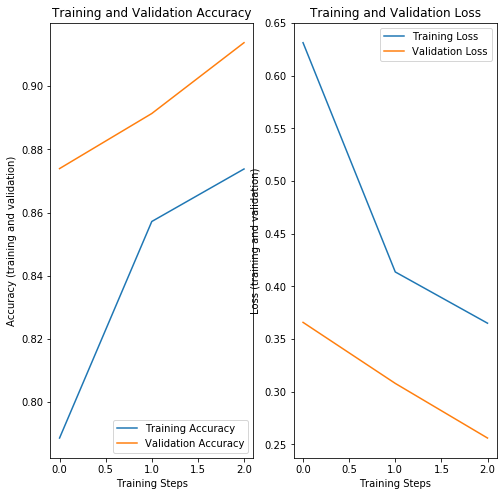

In [82]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/4dcc0165-a3c5-4290-8262-16c63b677a7d___GCREC_Bact.Sp 3602.JPG
PREDICTED: class: Tomato___Bacterial_spot, confidence: 0.943485


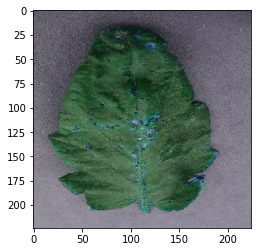

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/6cb5947c-d06a-4114-932e-ca1b952326c7___GCREC_Bact.Sp 3568.JPG
PREDICTED: class: Tomato___Bacterial_spot, confidence: 0.500112


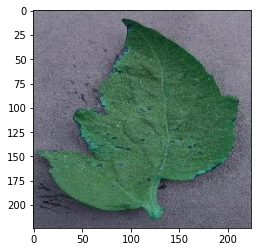

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/9ef056de-ae23-4271-823f-e951404348ce___YLCV_GCREC 5231.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.998013


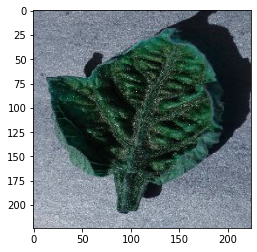

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/5c516463-b659-4ea8-ad79-d74b43b8ef5b___YLCV_NREC 2978.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.990173


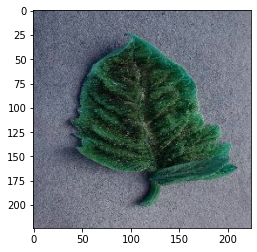

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/a66fa32e-e1bd-4bcb-9347-07989f88bcb5___UF.GRC_YLCV_Lab 02399.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.993006


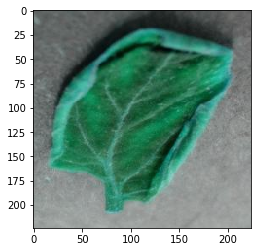

<Figure size 432x288 with 0 Axes>

In [83]:
import cv2
# Utility
import itertools
import random
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, test, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [0]:
model_json = model.to_json()
with open("tomato_model.json", "w") as json_file:
    json_file.write(model_json)
tf.keras.models.save_model(
    model,
    'tomato_model.h5')